In [1]:
import os
import numpy as np
import cv2 as cv
import time
from matplotlib import pyplot as plt
import json


TEMPLATES_PATH = 'templates/'
IMAGES_PATH = 'dataset/'
DATASET_JSON = 'dataset.json'

# Grid search parameters
MIN_MATCH_COUNTS = [3,5,10,15,20,25]
MAXDIST = [0.8, 0.85, 0.9, 0.95]
DETECTORS = ['ORB']
MATCHERS = ['BF']
MATCHERS_PARAMS = {
	'FLANN': {
		'trees': [5,10,20],
		'checks': [50]
	},
	'BF': {
		'crossCheck': [False],
	}
}


# 🛠️ Utilities

In [2]:
def get_RGB_from_BGR(img):
	return cv.cvtColor(img, cv.COLOR_BGR2RGB)

def get_tresh_from_path(img):
    img = cv.imread(img, cv.IMREAD_GRAYSCALE)
    _, img = cv.threshold(img, 128, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
    return img

In [3]:
def getKeypointDetectorAndNorm(name):
    if name == "SIFT":
        return cv.SIFT_create(), cv.NORM_L2
    elif name == "SURF":
        return cv.xfeatures2d.SURF_create(), cv.NORM_L2
    elif name == "ORB":
        return cv.ORB_create(scaleFactor=1.1), cv.NORM_HAMMING
    elif name == "BRISK":
        return cv.BRISK_create(), cv.NORM_HAMMING
    elif name == "AKAZE":
        return cv.AKAZE_create(), cv.NORM_HAMMING
    else:
        raise Exception("Unknown keypoint detector")

In [4]:
def getMatcher(name, params):
	if name == "FLANN":
		FLANN_INDEX_KDTREE = 1
		index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = params['trees'])
		search_params = dict(checks = params['checks'])	
		return cv.FlannBasedMatcher(index_params, search_params)
	elif name == "BF":
		return cv.BFMatcher(params['norm'], params['crossCheck'])
	else:
		raise Exception("Unknown matcher")

In [5]:
def center_crop(img, factor=0.97):
	# Cropping because many templates have angle brackets at the corners
	if factor != 1:
		height, width = img.shape[:2]
		# Calculate new dimensions
		new_height = int(height * factor)
		new_width = int(width * factor)

		# Calculate top-left corner and bottom-right corner for cropping
		start_x = (width - new_width) // 2
		start_y = (height - new_height) // 2
		end_x = start_x + new_width
		end_y = start_y + new_height

		# Crop the image
		return img[start_y:end_y, start_x:end_x]
	else:
		return img

In [6]:
def get_draw(kp_t, kp_img, template, full_img, good):
	src_pts = np.float32([ kp_t[m.queryIdx].pt for m in good]).reshape(-1,1,2)
	dst_pts = np.float32([ kp_img[m.trainIdx].pt for m in good]).reshape(-1,1,2)
	M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
	matchesMask = mask.ravel().tolist()
	template_img = cv.imread(template)
	img_img = cv.imread(full_img)
	h,w = template_img.shape[:2]
	pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
	dst = cv.perspectiveTransform(pts,M)
	img2 = cv.polylines(img_img,[np.int32(dst)],True,255,3, cv.LINE_AA)
	draw_params = dict(matchColor = (0,255,0), # draw matches in green color
				singlePointColor = None,
				matchesMask = matchesMask, # draw only inliers
				flags = 2)
	match_img = cv.drawMatches(template_img,kp_t,img2,kp_img,good,None,**draw_params)
	return match_img

def draw_match(match_img):
	plt.imshow(get_RGB_from_BGR(match_img))

In [7]:
def get_img_dicts(detector, treshold=False, scale=1):
	images = {}
	# Read dataset.json file
	with open(DATASET_JSON) as json_file:
		for tp in json.load(json_file)['true_positives']:
			images[tp['image']] = {
				'name' : tp['image'],
				'templates' : tp['templates']
			}

	for image in images:
		ref_img = get_tresh_from_path(IMAGES_PATH + image) if treshold else cv.imread(IMAGES_PATH + image)
		if scale != 1:
			ref_img = cv.resize(ref_img, (0,0), fx=scale, fy=scale)
		kp_image, des_image = detector.detectAndCompute(ref_img, None)
		images[image]['keypoints'] = kp_image
		images[image]['descriptors'] = des_image
	
	return images

def get_template_dicts(detector, treshold=False):
	templates = {}
	# Find all images in the templates folder
	for path in os.listdir(TEMPLATES_PATH):
		if not path == '.DS_Store':
			templates[path] = {
				'name': path
			}
	
	for template in templates:
		template_img = get_tresh_from_path(TEMPLATES_PATH + template) if treshold else cv.imread(TEMPLATES_PATH + template)
		#template_img = center_crop(template_img) # commenting this because the corner problem has been solved in the template preprocessing
		kp_template, des_template = detector.detectAndCompute(template_img, None)
		templates[template]['keypoints'] = kp_template
		templates[template]['descriptors'] = des_template
	return templates

def search_match(image, template, matcher, dist_max, min_match, save_draw=False, draw_on_found=False, verbose=False):
	kp_t, des_t = template['keypoints'], template['descriptors']
	kp_img, des_img = image['keypoints'], image['descriptors']

	should_be_found = template['name'] in image['templates']

	good = []
	if dist_max == -1:
		matches = matcher.knnMatch(des_t,des_img,k=1)
		for m in matches:
			if not m == ():
				good.append(m)
	else:
		matches = matcher.knnMatch(des_t,des_img,k=2)
		for m,n in matches:
			if m.distance < dist_max*n.distance:
				good.append(m)

	if len(good)>min_match:
		outcome = 'TP' if should_be_found else 'FP'
		if verbose:
			print(f"{outcome} found for {template['name']} on image {image['name']} with {len(good)} matches out of {min_match}")
		if save_draw:
			try:
				draw = get_draw(kp_t, kp_img, TEMPLATES_PATH+template['name'], IMAGES_PATH+image['name'], good)
			except:
				if verbose:
					print(f"[ERROR] Couldn't draw match for {template['name']} on image {image['name']} Skipping this draw")
				draw = None
			if draw_on_found:
				draw_match(draw)
		else:
			draw = None
		return draw, outcome
	else:
		outcome = 'TN' if not should_be_found else 'FN'
		if verbose:
			print(f"{outcome} found for {template['name']} on image {image['name']} with {len(good)} matches out of {min_match}")
		return None, outcome

In [8]:
def run_experiment(templates, detector, matcher, dist_max, min_match, verbose=False):
	results = {
		'TP' : [],
		'FP' : [],
		'TN' : [],
		'FN' : []
	}

	#templates, images = get_dicts(detector)
	images = get_img_dicts(detector)

	for image in images:
		for template in templates:
			draw, outcome = search_match(images[image], templates[template], matcher, dist_max, min_match, verbose=verbose)
			results[outcome].append("." if draw is None else draw)

	print(f"TP: {len(results['TP'])}, FP: {len(results['FP'])}, TN: {len(results['TN'])}, FN: {len(results['FN'])}")
	return results

In [9]:
# Perform grid search
for detector_name in DETECTORS:
	detector, norm = getKeypointDetectorAndNorm(detector_name)
	templates = get_template_dicts(detector)
	for matcher_name in MATCHERS:
		if matcher_name == 'BF':
			for crossCheck in MATCHERS_PARAMS[matcher_name]['crossCheck']:
				matcher = getMatcher(matcher_name, {'norm': norm, 'crossCheck': crossCheck})
				MAXDIST_ITER = [-1] if crossCheck else MAXDIST
				for dist_max in MAXDIST_ITER:
					for min_match in MIN_MATCH_COUNTS:
						print("\n=====================================")
						print(f"Starting run with detector: {detector_name}, matcher: {matcher_name}, crossCheck: {crossCheck}, dist_max: {dist_max}, min_match: {min_match}")
						start_time = time.time()
						try:
							results = run_experiment(templates, detector, matcher, dist_max, min_match)
						except Exception as e:
							print(f"[ERROR] Couldn't run experiment -> {e}")
						end_time = time.time()
						print(f"Time taken: {end_time - start_time} seconds")
		elif matcher_name == 'FLANN':
			for trees in MATCHERS_PARAMS[matcher_name]['trees']:
				for checks in MATCHERS_PARAMS[matcher_name]['checks']:
						matcher = getMatcher(matcher_name, {'trees': trees, 'checks': checks})
						for dist_max in MAXDIST:
							for min_match in MIN_MATCH_COUNTS:
								print("\n=====================================")
								print(f"Starting run with detector: {detector_name}, matcher: {matcher_name}, trees: {trees}, checks: {checks}, dist_max: {dist_max}, min_match: {min_match}")
								start_time = time.time()
								try:
									run_experiment(templates, detector, matcher, dist_max, min_match)
								except Exception as e:
									print(f"[ERROR] Couldn't run experiment -> {e}")
								end_time = time.time()
								print(f"Time taken: {end_time - start_time} seconds")
		else:
			raise Exception("Unknown matcher")
			


Starting run with detector: ORB, matcher: BF, crossCheck: False, dist_max: 0.8, min_match: 3
TP: 3, FP: 690, TN: 63001, FN: 10
Time taken: 1.7693839073181152 seconds

Starting run with detector: ORB, matcher: BF, crossCheck: False, dist_max: 0.8, min_match: 5
TP: 2, FP: 270, TN: 63421, FN: 11
Time taken: 1.4676620960235596 seconds

Starting run with detector: ORB, matcher: BF, crossCheck: False, dist_max: 0.8, min_match: 10
TP: 2, FP: 22, TN: 63669, FN: 11
Time taken: 1.474397897720337 seconds

Starting run with detector: ORB, matcher: BF, crossCheck: False, dist_max: 0.8, min_match: 15
TP: 1, FP: 3, TN: 63688, FN: 12
Time taken: 1.4520890712738037 seconds

Starting run with detector: ORB, matcher: BF, crossCheck: False, dist_max: 0.8, min_match: 20
TP: 0, FP: 0, TN: 63691, FN: 13
Time taken: 1.4001190662384033 seconds

Starting run with detector: ORB, matcher: BF, crossCheck: False, dist_max: 0.8, min_match: 25
TP: 0, FP: 0, TN: 63691, FN: 13
Time taken: 1.4287869930267334 seconds

S

In [10]:
# to_draw = [ # image , template
#     ["test_00000.jpg", "ISO7000_02382.png"], # FP,
#     ["test_00000.jpg","ISO7000_03063.png"], # FP,
#     ["test_00000.jpg","GHS_00012.png"], #TP
#     ["test_00007.jpeg", "Recycle_00042.png"], # TP,
#     ["test_00007.jpeg", "ISO7000_02678.png"], # FP,
# ]

to_draw = [
    ["test_00007.jpeg","ISO7000_04181.png"]
]

templates = get_template_dicts(detector)
images = get_img_dicts(detector)


In [11]:
# sort templates by the number of keypoints descending then print the top 20
sorted_templates = sorted(templates.items(), key=lambda x: len(x[1]['keypoints']), reverse=True)
print("Top 20 templates by number of keypoints:")
for i in range(20):
	print(f"{sorted_templates[i][0]}: {len(sorted_templates[i][1]['keypoints'])} keypoints")
	


Top 20 templates by number of keypoints:
GHS_00020.png: 316 keypoints
ISO7010_E025.png: 288 keypoints
ISO7010_P070.png: 287 keypoints
ISO7010_P040.png: 283 keypoints
ISO7010_P039.png: 276 keypoints
ISO7010_P033.png: 275 keypoints
ISO7010_E060.png: 273 keypoints
ISO7010_E032.png: 270 keypoints
GHS_00015.png: 268 keypoints
ISO7010_E068.png: 260 keypoints
ISO7010_P023.png: 260 keypoints
ISO7010_F019.png: 259 keypoints
ISO7010_P065.png: 257 keypoints
ISO7010_E051.png: 251 keypoints
ISO7010_P034.png: 251 keypoints
GHS_00019.png: 248 keypoints
ISO7010_P028.png: 241 keypoints
ISO7010_E017.png: 238 keypoints
ISO7010_P011.png: 234 keypoints
ISO7010_P009.png: 234 keypoints


{'whiskers': [<matplotlib.lines.Line2D at 0x1a41a8ce0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a41a9250>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a40f47a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a41a9850>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a41a9b50>],
 'means': []}

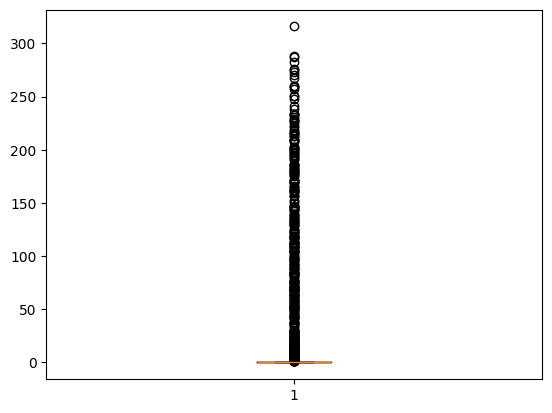

In [12]:
plt.boxplot([len(templates[template]['keypoints']) for template in templates])

(array([7.208e+03, 1.530e+02, 9.800e+01, 8.900e+01, 4.900e+01, 3.300e+01,
        1.300e+01, 1.200e+01, 6.000e+00, 1.000e+01, 2.000e+00, 6.000e+00,
        2.000e+00, 7.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 4.000e+00,
        7.000e+00, 9.000e+00, 3.000e+00, 9.000e+00, 8.000e+00, 3.000e+00,
        8.000e+00, 5.000e+00, 8.000e+00, 2.000e+00, 4.000e+00, 6.000e+00,
        6.000e+00, 4.000e+00, 3.000e+00, 7.000e+00, 7.000e+00, 8.000e+00,
        2.000e+00, 7.000e+00, 5.000e+00, 3.000e+00, 3.000e+00, 4.000e+00,
        5.000e+00, 4.000e+00, 3.000e+00, 5.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        4.000e+00, 3.000e+00, 6.000e+00, 4.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 4.000e+00, 3.000e+00, 5.000e+00, 2.000e+00, 2.000e+00,
        4.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 0.000e+0

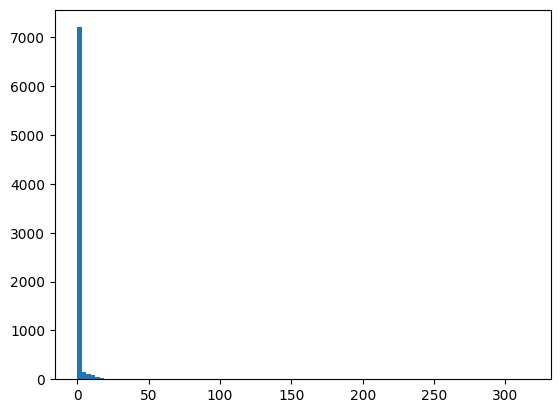

In [13]:
plt.hist([len(templates[template]['keypoints']) for template in templates], bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x1a4366a80>,
 'caps': [<matplotlib.lines.Line2D at 0x1a4366ff0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a43668a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a4367530>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a4367800>],
 'means': []}

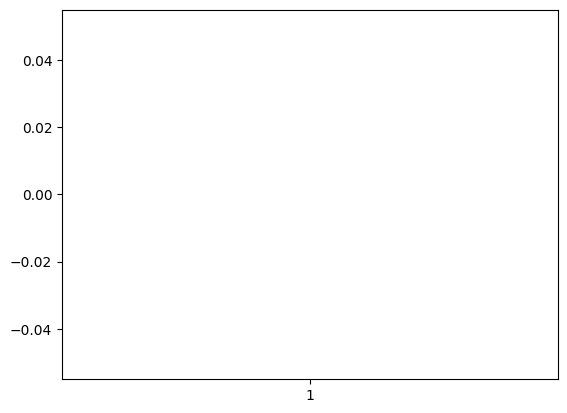

In [14]:
responses = [kp.response for kp in templates['ISO7000_04181.png']['keypoints']]
plt.boxplot(responses)